## How much tracer is there on the shelf?

This notebook explores the effects of changing the vertical diffusivity (constant, 3D), changing the isopycnal diffusivity in GMREDI and having a canyon vs a flat shelf on the total amount of tracer (mass) on the shelf at a certain time and place.

In [1]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

/home/kramosmu/anaconda/lib/python2.7/site-packages/mpl_toolkits/__init__.py:2: UserWarning: Module MITgcmutils was already imported from MITgcmutils/__init__.pyc, but /home/kramosmu/anaconda/lib/python2.7/site-packages/MITgcmutils-0.1.0-py2.7.egg is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)


In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 


In [3]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('talk')

In [4]:
#Varying-K_iso runs CNTDIFF:
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run02/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CNTrun02 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run02/stateGlob.nc'
StateOut02 = Dataset(CNTrun02)

CNTrun02Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run02/ptracersGlob.nc'
CNTrun03Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/ptracersGlob.nc'
CNTrun04Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run04/ptracersGlob.nc'

#Varying-K_v 3D runs
DIFF3Drun01Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run01/ptracersGlob.nc'
DIFF3Drun02Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run02/ptracersGlob.nc'
DIFF3Drun03Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run03/ptracersGlob.nc'

#No Canyon run CNTDIFF
NoCGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'
NoCGridOut = Dataset(NoCGrid)
CNTrun07Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/ptracersGlob.nc'

#No GMREDI runs
NOREDI02Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run02/ptracersGlob.nc'
NOREDI03Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run03/ptracersGlob.nc'
NOREDI04Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run04/ptracersGlob.nc' # No canyon case
NOREDI05Tr = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run05/ptracersGlob.nc' # Closed Bdies


In [6]:
# General input

nx = 360
ny = 360
nz = 90

nt = 19 # t dimension size 

z = StateOut02.variables['Z']
#print(z[10])
Time = StateOut02.variables['T']
#print(Time[:])
xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells

drF = CanyonGridOut.variables['drF'] # vertical distance between faces
dxG = rout.getField(CanyonGrid,'dxG')
bathy = rout.getField(CanyonGrid, 'Depth')

rA = rout.getField(CanyonGrid, 'rA') # area of cells (x-y)
hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid,'HFacC') # same for both runs

MaskNoC = rout.getMask(NoCGrid,'HFacC') 
hFacCNoC = rout.getField(NoCGrid,'HFacC') 
rANoC = rout.getField(NoCGrid,'rA') 
drFNoC= NoCGridOut.variables['drF']

In [9]:
# Load tracers variable K_iso
Tr1Iso10 = rout.getField(CNTrun02Tr,'Tr1') # Tracer 1 CNT run02 , Kz = E-5
Tr3Iso10 = rout.getField(CNTrun02Tr,'Tr3') # Tracer 3 CNT run02 , Kz = E-3
Tr1Iso1 = rout.getField(CNTrun03Tr,'Tr1') # Tracer 1 CNT run03 , Kz = E-5
Tr3Iso1 = rout.getField(CNTrun03Tr,'Tr3') # Tracer 3 CNT run03 , Kz = E-3
Tr1Iso01 = rout.getField(CNTrun04Tr,'Tr1') # Tracer 1 CNT run04 , Kz = E-5
Tr3Iso01 = rout.getField(CNTrun04Tr,'Tr3') # Tracer 3 CNT run04 , Kz = E-3



In [8]:
# Load tracers variable K_v
Tr13D = rout.getField(DIFF3Drun01Tr,'Tr1') # Tracer 1 3D run01 , Kz = E-7 out, E-3 in
Tr23D = rout.getField(DIFF3Drun02Tr,'Tr1') # Tracer 1 3D run02 , Kz = E-7 out, E-4 in
Tr33D = rout.getField(DIFF3Drun03Tr,'Tr1') # Tracer 1 3D run03 , Kz = E-5 out, E-3 in


In [11]:
# Load tracers of no canyon run
Tr1NoC = rout.getField(CNTrun07Tr,'Tr1') # Tracer 1 NoC run17CNT , Kz = E-5
Tr3NoC = rout.getField(CNTrun07Tr,'Tr3') # Tracer 2 NoC run17CNT , Kz = E-3 
Tr1NoRNoC = rout.getField(NOREDI04Tr,'Tr1') # Tracer 1 NoC NoR run04 No Redi , Kz = E-5
#Tr2NoRNoC = rout.getField(NoREDI04Tr,'Tr2') # Tracer 2 NoC NoR run04 No redi , Kz = E-4 
Tr3NoRNoC = rout.getField(NOREDI04Tr,'Tr3') # Tracer 3 NoC NoR run04 No redi , Kz = E-3 


In [12]:
# Load tracers of no REDI run
Tr1NoREDI02 = rout.getField(NOREDI02Tr,'Tr1') # Tracer 1 NoREDI run02 , Kz = E-5
#Tr2NoREDI02 = rout.getField(NOREDI02Tr,'Tr2') # Tracer 2 NoREDI run02 , Kz = E-4 
Tr3NoREDI02 = rout.getField(NOREDI02Tr,'Tr3') # Tracer 3 NoREDI run02 , Kz = E-3 
Tr1NoREDI03 = rout.getField(NOREDI03Tr,'Tr1') # Tracer 1 NoREDI run03 , Kz = E-5
#Tr2NoREDI03 = rout.getField(NOREDI03Tr,'Tr2') # Tracer 2 NoREDI run03 , Kz = E-4 
Tr3NoREDI03 = rout.getField(NOREDI03Tr,'Tr3') # Tracer 3 NoREDI run03 , Kz = E-3 
Tr1NoREDI05 = rout.getField(NOREDI05Tr,'Tr1') # Tracer 1 NoREDI run05 Closed Bdies
#Tr2NoREDI05 = rout.getField(NOREDI05Tr,'Tr2') # Tracer 2 NoREDI run05 Closed Bdies
Tr3NoREDI05 = rout.getField(NOREDI05Tr,'Tr3') # Tracer 3 NoREDI run05 Closed Bdies




### How much water with concentration higher than a limit is there on the shelf at each time? How much tracer mass?

In [13]:
def HowMuchWaterX(Tr,MaskC,nzlim,rA,hFacC,drF,tt,nx,dx):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    tt    : Time slice to calculate. Int 0<=tt<19
    nx    : x dimension (along shelf) 
    dx    : 
    OUTPUT----------------------------------------------------------------------------------------------------------------
    WaterX = (360) Arrays with the volume of water at each x-position over the shelf [tt,:28,:197,xx]
    TrX = (360) Arrays with the mass of tracer (umol) at each x-position over the shelf [tt,:28,:197,xx]. 
          Total mass of tracer at xx on the shelf.
                                                
    -----------------------------------------------------------------------------------------------------------------------
    '''
    WaterX= np.zeros(nx)
    TrX= np.zeros(nx)
  
    TrMask0=np.ma.array(Tr[0,:,:,:],mask=MaskC[:,:,:])
        
    trlim = TrMask0[nzlim,50,180]
    
    hFacCSwap = np.swapaxes(hFacC, 0, 2)
    
    #print('tracer limit is: ',trlim)
    
    TrMask=np.ma.array(Tr[tt,:,:,:],mask=MaskC[:,:,:])
    
    for ii,trac in np.ndenumerate(TrMask[:28,197:,:]) :
        if trac >= trlim:
             WaterX[ii[2]] = WaterX[ii[2]] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]/dx[ii[1],ii[2]]
                
                
    VolX = (np.swapaxes(hFacCSwap[:,197:,:28]*drF[:28],0,2))*rA[197:,:]
          
    TrX[:] = np.sum(np.sum((VolX*TrMask[:28,197:,:]*1000.0),axis=0),axis=0)/dx[0,:] #[1 umol/l=1000 umol/m^3]
     
    
    
    return(WaterX,TrX)

### Case 1: Changing $K_{iso}$ in GMREDI

In [15]:
TotWatXTr1Iso10 = np.empty(nt)
TotWatXTr3Iso10 = np.empty(nt)
TotWatXTr1Iso1 = np.empty(nt)
TotWatXTr3Iso1 = np.empty(nt)
TotWatXTr1Iso01 = np.empty(nt)
TotWatXTr3Iso01 = np.empty(nt)
TotWatXTr1NoREDI02 = np.empty(nt)
TotWatXTr3NoREDI02 = np.empty(nt)


TotXTr1Iso10 = np.empty(nt)
TotXTr3Iso10 = np.empty(nt)
TotXTr1Iso1 = np.empty(nt)
TotXTr3Iso1 = np.empty(nt)
TotXTr1Iso01 = np.empty(nt)
TotXTr3Iso01 = np.empty(nt)
TotXTr1NoREDI02 = np.empty(nt)
TotXTr3NoREDI02 = np.empty(nt)




for time in range(0,nt,1):
    print(time)    
    (WaterX1, TrX1) = HowMuchWaterX(Tr1Iso10,MaskNoC,29,rANoC,hFacCNoC,drFNoC,time,nx,dxG) # Use NoC quantities so that the canyon is not counted
    (WaterX2, TrX2) = HowMuchWaterX(Tr3Iso10,MaskNoC,29,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX3, TrX3) = HowMuchWaterX(Tr1Iso1,MaskNoC,29,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX4, TrX4) = HowMuchWaterX(Tr3Iso1,MaskNoC,29,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX5, TrX5) = HowMuchWaterX(Tr1Iso01,MaskNoC,29,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX6, TrX6) = HowMuchWaterX(Tr3Iso01,MaskNoC,29,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX7, TrX7) = HowMuchWaterX(Tr1NoREDI02,MaskNoC,29,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX8, TrX8) = HowMuchWaterX(Tr3NoREDI02,MaskNoC,29,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
        
    
    TotXTr1Iso10[time] = np.sum((TrX1)*dxG[0,:])
    TotWatXTr1Iso10[time] = np.sum((WaterX1)*dxG[0,:])
    
    TotXTr3Iso10[time] = np.sum((TrX2)*dxG[0,:])
    TotWatXTr3Iso10[time] = np.sum((WaterX2)*dxG[0,:])
    
    TotXTr1Iso1[time] = np.sum((TrX3)*dxG[0,:])
    TotWatXTr1Iso1[time] = np.sum((WaterX3)*dxG[0,:])
    
    TotXTr3Iso1[time] = np.sum((TrX4)*dxG[0,:])
    TotWatXTr3Iso1[time] = np.sum((WaterX4)*dxG[0,:])
    
    TotXTr1Iso01[time] = np.sum((TrX5)*dxG[0,:])
    TotWatXTr1Iso01[time] = np.sum((WaterX5)*dxG[0,:])
    
    TotXTr3Iso01[time] = np.sum((TrX6)*dxG[0,:])
    TotWatXTr3Iso01[time] = np.sum((WaterX6)*dxG[0,:])
    
    TotXTr1NoREDI02[time] = np.sum((TrX7)*dxG[0,:])
    TotWatXTr1NoREDI02[time] = np.sum((WaterX7)*dxG[0,:])
    
    TotXTr3NoREDI02[time] = np.sum((TrX8)*dxG[0,:])
    TotWatXTr3NoREDI02[time] = np.sum((WaterX8)*dxG[0,:])
    
        
        


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


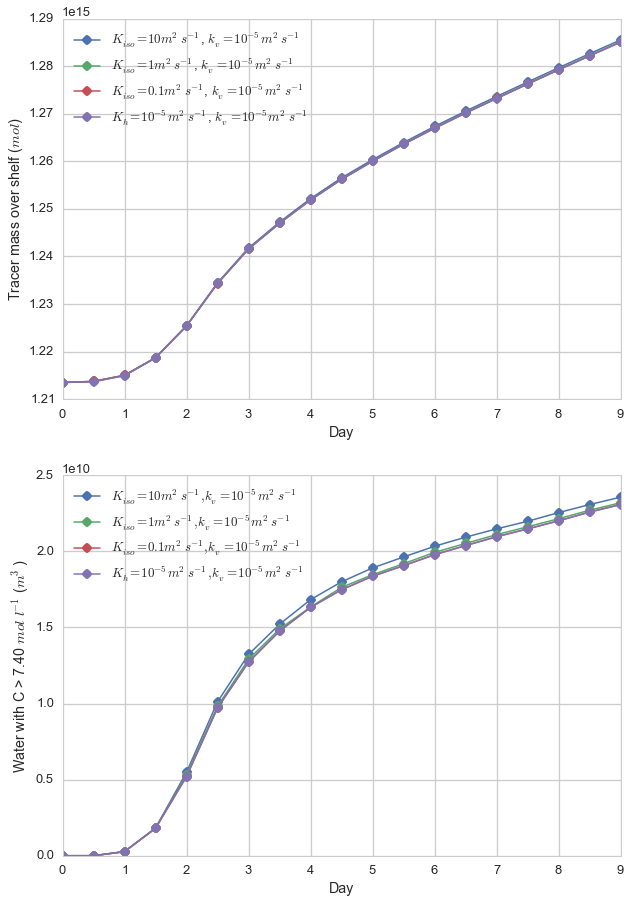

In [22]:
fig45=plt.figure(figsize=(10,15))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)


ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TotXTr1Iso10,'o-',label='$K_{iso}=10m^2s^{-1}$, $k_v=10^{-5}m^2s^{-1}$')
line2 = ax1.plot(times/2.0, TotXTr1Iso1,'o-', label='$K_{iso}=1m^2s^{-1}$, $k_v=10^{-5}m^2s^{-1}$')
line3 = ax1.plot(times/2.0, TotXTr1Iso01,'o-', label='$K_{iso}=0.1m^2s^{-1}$, $k_v=10^{-5}m^2s^{-1}$')
line4 = ax1.plot(times/2.0, TotXTr1NoREDI02,'o-', label='$K_{h}=10^{-5}m^2s^{-1}$, $k_v=10^{-5}m^2s^{-1}$')

plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, TotWatXTr1Iso10,'o-',label='$K_{iso}=10m^2s^{-1}, k_v=10^{-5}m^2s^{-1}$')
line2 = ax2.plot(times/2.0, TotWatXTr1Iso1,'o-', label='$K_{iso}=1m^2s^{-1}, k_v=10^{-5}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, TotWatXTr1Iso01,'o-', label='$K_{iso}=0.1m^2s^{-1}, k_v=10^{-5}m^2s^{-1}$')
line4 = ax2.plot(times/2.0, TotWatXTr1NoREDI02,'o-', label='$K_{h}=10^{-5}m^2s^{-1}, k_v=10^{-5}m^2s^{-1}$')

plt.ylabel('Water with C > 7.40 $mol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr1.eps', format='eps', dpi=1000, bbox_inches='tight')


In [18]:
print('%e mol' %(TotXTr1Iso01[18]-TotXTr1Iso01[0]))
print('%e mol' %(TotXTr1Iso1[18]-TotXTr1Iso1[0]))
print('%e mol' %(TotXTr1Iso10[18]-TotXTr1Iso10[0]))
print('%e mol' %(TotXTr1NoREDI02[18]-TotXTr1NoREDI02[0]))


7.156459e+13 mol
7.163881e+13 mol
7.203798e+13 mol
7.156162e+13 mol


The yellow line is underneath the cyan


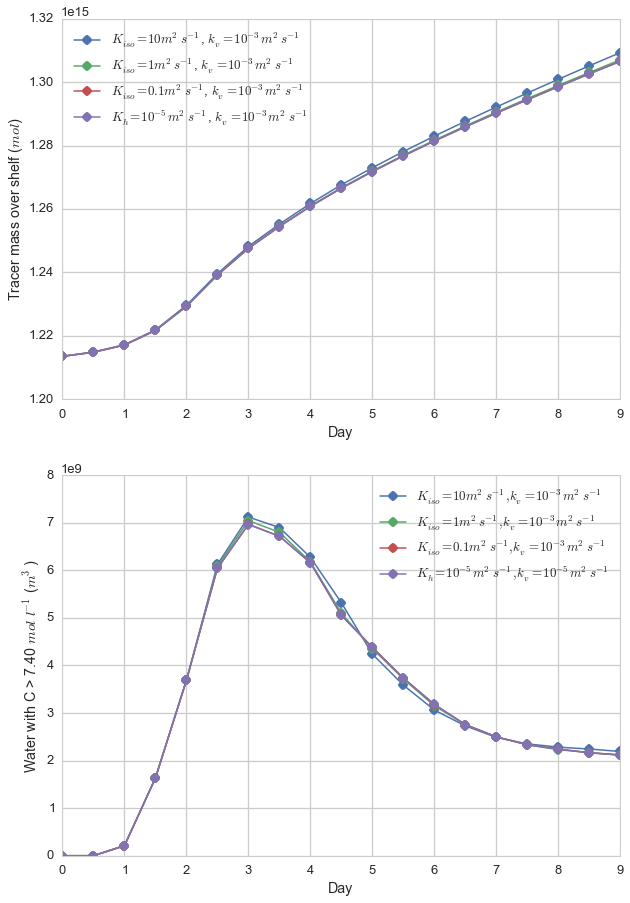

In [21]:
fig45=plt.figure(figsize=(10,15))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)


ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TotXTr3Iso10[:],'o-',label='$K_{iso}=10m^2s^{-1}$, $k_v=10^{-3}m^2s^{-1}$')
line2 = ax1.plot(times/2.0, TotXTr3Iso1[:],'o-', label='$K_{iso}=1m^2s^{-1}$, $k_v=10^{-3}m^2s^{-1}$')
line3 = ax1.plot(times/2.0, TotXTr3Iso01[:],'o-', label='$K_{iso}=0.1m^2s^{-1}$, $k_v=10^{-3}m^2s^{-1}$')
line4 = ax1.plot(times/2.0, TotXTr3NoREDI02[:],'o-', label='$K_{h}=10^{-5}m^2s^{-1}$, $k_v=10^{-3}m^2s^{-1}$')

plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, TotWatXTr3Iso10[:],'o-',label='$K_{iso}=10m^2s^{-1}, k_v=10^{-3}m^2s^{-1}$')
line2 = ax2.plot(times/2.0, TotWatXTr3Iso1[:],'o-', label='$K_{iso}=1m^2s^{-1}, k_v=10^{-3}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, TotWatXTr3Iso01[:],'o-', label='$K_{iso}=0.1m^2s^{-1}, k_v=10^{-3}m^2s^{-1}$')
line4 = ax2.plot(times/2.0, TotWatXTr3NoREDI02[:],'o-', label='$K_{h}=10^{-5}m^2s^{-1}, k_v=10^{-5}m^2s^{-1}$')


plt.ylabel('Water with C > 7.40 $mol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/MassOverShelfIsoEffectTr3.eps', format='eps', dpi=1000, bbox_inches='tight')


In [23]:
print('%e mol' %(TotXTr3Iso01[18]-TotXTr3Iso01[0]))
print('%e mol' %(TotXTr3Iso1[18]-TotXTr3Iso1[0]))
print('%e mol' %(TotXTr3Iso10[18]-TotXTr3Iso10[0]))
print('%e mol' %(TotXTr3NoREDI02[18]-TotXTr3NoREDI02[0]))


9.308887e+13 mol
9.355133e+13 mol
9.583041e+13 mol
9.303499e+13 mol


### Case 2: Enhanced mixing inside the canyon (3D vertical diffusivity)


In [24]:
TotWatXTr13D = np.empty(nt)
TotWatXTr23D = np.empty(nt)
TotWatXTr33D = np.empty(nt)


TotXTr13D = np.empty(nt)
TotXTr23D = np.empty(nt)
TotXTr33D = np.empty(nt)

for time in range(0,nt,1):
    print(time)    
    (WaterX1, TrX1) = HowMuchWaterX(Tr13D,MaskNoC,29,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX2, TrX2) = HowMuchWaterX(Tr23D,MaskNoC,29,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX3, TrX3) = HowMuchWaterX(Tr33D,MaskNoC,29,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
    
    TotXTr13D[time] = np.sum((TrX1)*dxG[0,:])
    TotWatXTr13D[time] = np.sum((WaterX1)*dxG[0,:])
    TotXTr23D[time] = np.sum((TrX2)*dxG[0,:])
    TotWatXTr23D[time] = np.sum((WaterX2)*dxG[0,:])
    TotXTr33D[time] = np.sum((TrX3)*dxG[0,:])
    TotWatXTr33D[time] = np.sum((WaterX3)*dxG[0,:])
    
        


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


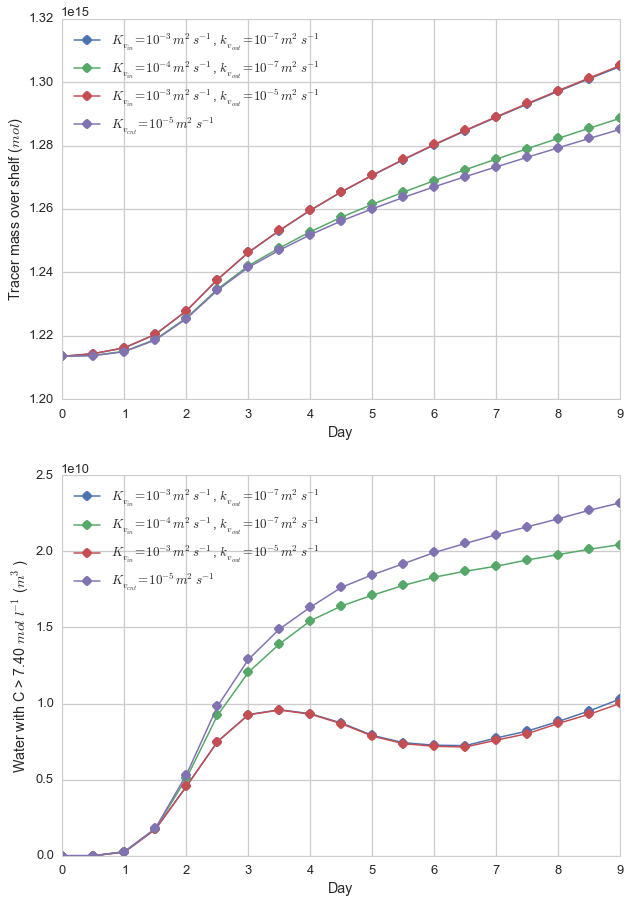

In [26]:
fig45=plt.figure(figsize=(10,15))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)


ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TotXTr13D,'o-',label='$K_{v_{in}}=10^{-3}m^2s^{-1}$, $k_{v_{out}}=10^{-7}m^2s^{-1}$')
line2 = ax1.plot(times/2.0, TotXTr23D,'o-', label='$K_{v_{in}}=10^{-4}m^2s^{-1}$, $k_{v_{out}}=10^{-7}m^2s^{-1}$')
line3 = ax1.plot(times/2.0, TotXTr33D,'o-', label='$K_{v_{in}}=10^{-3}m^2s^{-1}$, $k_{v_{out}}=10^{-5}m^2s^{-1}$')
line3 = ax1.plot(times/2.0, TotXTr1Iso1,'o-', label='$K_{v_{cnt}}=10^{-5}m^2s^{-1}$')


plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, TotWatXTr13D,'o-',label='$K_{v_{in}}=10^{-3}m^2s^{-1}$, $k_{v_{out}}=10^{-7}m^2s^{-1}$')
line2 = ax2.plot(times/2.0, TotWatXTr23D,'o-', label='$K_{v_{in}}=10^{-4}m^2s^{-1}$, $k_{v_{out}}=10^{-7}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, TotWatXTr33D,'o-', label='$K_{v_{in}}=10^{-3}m^2s^{-1}$, $k_{v_{out}}=10^{-5}m^2s^{-1}$')
line4 = ax2.plot(times/2.0, TotWatXTr1Iso1,'o-', label='$K_{v_{cnt}}=10^{-5}m^2s^{-1}$')



plt.ylabel('Water with C > 7.40 $mol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/TrMassOverShelf3DDIFF.eps', format='eps', dpi=1000, bbox_inches='tight')


In [27]:
print('Delta m =%e mol' %(TotXTr13D[18]-TotXTr13D[0]))
print('Delta m =%e mol' %(TotXTr23D[18]-TotXTr23D[0]))
print('Delta m =%e mol' %(TotXTr33D[18]-TotXTr33D[0]))


Delta m =9.145879e+13 mol
Delta m =7.512872e+13 mol
Delta m =9.174763e+13 mol


### Case 3: Canyon effect 3DDIFF and Redi

In [28]:
TotWatXTr1NoC = np.empty(nt)
TotWatXTr3NoC = np.empty(nt)

TotXTr1NoC = np.empty(nt)
TotXTr3NoC = np.empty(nt)


for time in range(0,nt,1):
    print(time)    
    (WaterX1, TrX1) = HowMuchWaterX(Tr1NoC,MaskNoC,29,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX2, TrX2) = HowMuchWaterX(Tr3NoC,MaskNoC,29,rANoC,hFacCNoC,drFNoC,time,nx,dxG)
        
    TotXTr1NoC[time] = np.sum((TrX1)*dxG[0,:])
    TotWatXTr1NoC[time] = np.sum((WaterX1)*dxG[0,:])
    
    TotXTr3NoC[time] = np.sum((TrX2)*dxG[0,:])
    TotWatXTr3NoC[time] = np.sum((WaterX2)*dxG[0,:])
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


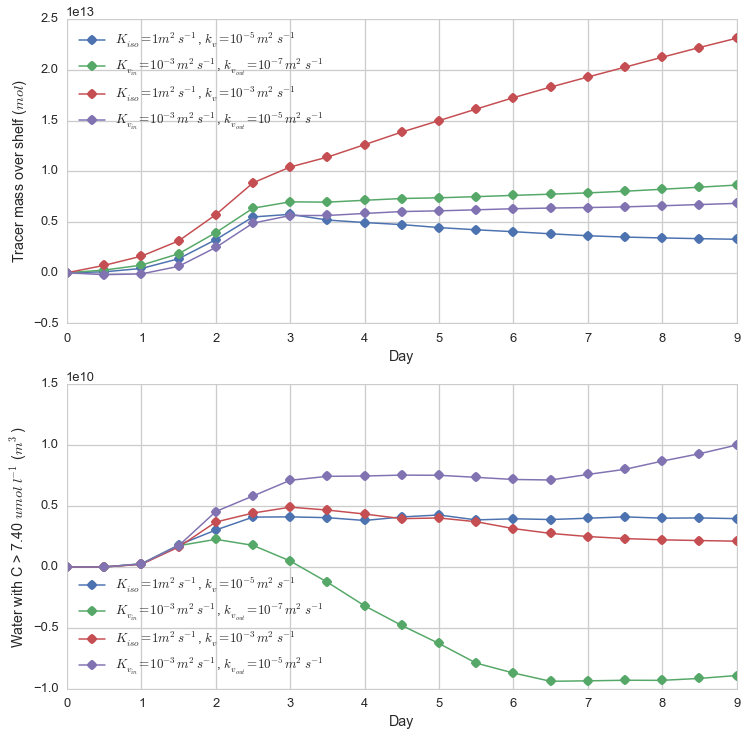

In [30]:
fig45=plt.figure(figsize=(12,12))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)

ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TotXTr1Iso1-TotXTr1NoC,'o-',label='$K_{iso}=1 m^2s^{-1}$, $k_{v}=10^{-5}m^2s^{-1}$')
line2 = ax1.plot(times/2.0, TotXTr3Iso1-TotXTr3NoC,'o-',label='$K_{v_{in}}=10^{-3}m^2s^{-1}$, $k_{v_{out}}=10^{-7}m^2s^{-1}$')

line3 = ax1.plot(times/2.0, TotXTr13D-TotXTr1NoC,'o-', label='$K_{iso}=1 m^2s^{-1}$, $k_{v}=10^{-3}m^2s^{-1}$')
line4 = ax1.plot(times/2.0, TotXTr33D-TotXTr3NoC,'o-', label='$K_{v_{in}}=10^{-3}m^2s^{-1}$, $k_{v_{out}}=10^{-5}m^2s^{-1}$')


plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, TotWatXTr1Iso1-TotWatXTr1NoC,'o-',label='$K_{iso}=1 m^2s^{-1}$, $k_{v}=10^{-5}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, TotWatXTr13D-TotWatXTr1NoC,'o-', label='$K_{v_{in}}=10^{-3}m^2s^{-1}$, $k_{v_{out}}=10^{-7}m^2s^{-1}$')

line1 = ax2.plot(times/2.0, TotWatXTr3Iso1-TotWatXTr3NoC,'o-',label='$K_{iso}=1 m^2s^{-1}$, $k_{v}=10^{-3}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, TotWatXTr33D-TotWatXTr3NoC,'o-', label='$K_{v_{in}}=10^{-3}m^2s^{-1}$, $k_{v_{out}}=10^{-5}m^2s^{-1}$')



plt.ylabel('Water with C > 7.40 $umol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/TrMassOverShelfCNT3DNoC.eps', format='eps', dpi=1000, bbox_inches='tight')


In [ ]:
print('%e' %TotWatXTr1NoC[18]-TotWatXTr1NoC[0])

In [20]:
TotWatXTr1Iso1 = np.empty(nt)
TotWatXTr2Iso1 = np.empty(nt)
TotWatXTr1NoC = np.empty(nt)
TotWatXTr2NoC = np.empty(nt)

TotXTr2Iso1 = np.empty(nt)
TotXTr1Iso1 = np.empty(nt)
TotXTr1NoC = np.empty(nt)
TotXTr2NoC = np.empty(nt)

for time in range(0,nt,1):
    print(time)    
    (WaterX1, TrX1) = HowMuchWaterX(Tr1Iso1,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX2, TrX2) = HowMuchWaterX(Tr2Iso1,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX3, TrX3) = HowMuchWaterX(Tr1NoC,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX4, TrX4) = HowMuchWaterX(Tr2NoC,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
        
    TotXTr1Iso1[time] = np.sum((TrX1)*dxG[0,:])
    TotWatXTr1Iso1[time] = np.sum((WaterX1)*dxG[0,:])
    TotXTr2Iso1[time] = np.sum((TrX2)*dxG[0,:])
    TotWatXTr2Iso1[time] = np.sum((WaterX2)*dxG[0,:])
    TotXTr1NoC[time] = np.sum((TrX3)*dxG[0,:])
    TotWatXTr1NoC[time] = np.sum((WaterX3)*dxG[0,:])
    TotXTr2NoC[time] = np.sum((TrX4)*dxG[0,:])
    TotWatXTr2NoC[time] = np.sum((WaterX4)*dxG[0,:])
        
        


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


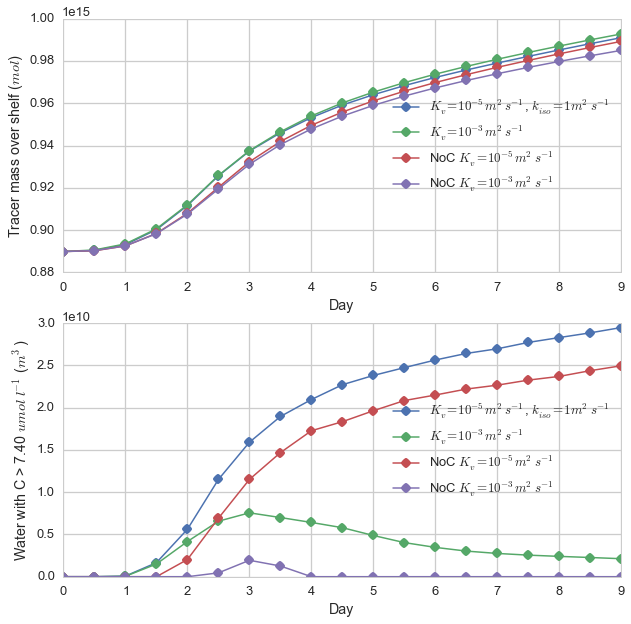

In [21]:
fig45=plt.figure(figsize=(10,10))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)


ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TotXTr1Iso1,'o-',label='$K_{v}=10^{-5}m^2s^{-1}$, $k_{iso}=1m^2s^{-1}$')
line2 = ax1.plot(times/2.0, TotXTr2Iso1,'o-', label='$K_{v}=10^{-3}m^2s^{-1}$ ')
line3 = ax1.plot(times/2.0, TotXTr1NoC,'o-', label='NoC $K_{v}=10^{-5}m^2s^{-1}$')
line3 = ax1.plot(times/2.0, TotXTr2NoC,'o-', label='NoC $K_{v}=10^{-3}m^2s^{-1}$')


plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, TotWatXTr1Iso1,'o-',label='$K_{v}=10^{-5}m^2s^{-1}$, $k_{iso}=1m^2s^{-1}$')
line2 = ax2.plot(times/2.0, TotWatXTr2Iso1,'o-', label='$K_{v}=10^{-3}m^2s^{-1}$')
line3 = ax2.plot(times/2.0, TotWatXTr1NoC,'o-', label='NoC $K_{v}=10^{-5}m^2s^{-1}$')
line4 = ax2.plot(times/2.0, TotWatXTr2NoC,'o-', label='NoC $K_{v}=10^{-3}m^2s^{-1}$')



plt.ylabel('Water with C > 7.40 $umol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=5)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=5)


#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/TrMassOverShelfCNT13DNoC1.eps', format='eps', dpi=1000,bbox_extra_artists=(leg,), bbox_inches='tight')


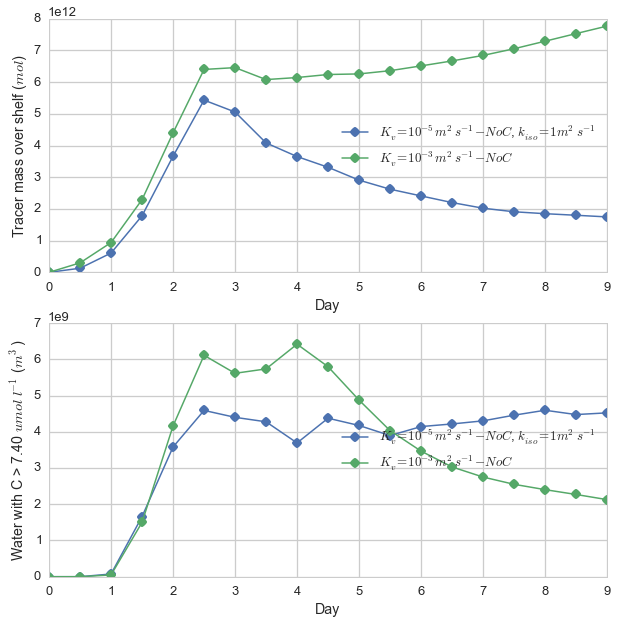

In [22]:
fig45=plt.figure(figsize=(10,10))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)


ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TotXTr1Iso1-TotXTr1NoC,'o-',label='$K_{v}=10^{-5}m^2s^{-1} - NoC$, $k_{iso}=1m^2s^{-1}$')
line2 = ax1.plot(times/2.0, TotXTr2Iso1-TotXTr2NoC,'o-', label='$K_{v}=10^{-3}m^2s^{-1} - NoC$ ')


plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, TotWatXTr1Iso1-TotWatXTr1NoC,'o-',label='$K_{v}=10^{-5}m^2s^{-1}-NoC$, $k_{iso}=1m^2s^{-1}$')
line2 = ax2.plot(times/2.0, TotWatXTr2Iso1-TotWatXTr2NoC,'o-', label='$K_{v}=10^{-3}m^2s^{-1}-NoC$')



plt.ylabel('Water with C > 7.40 $umol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=5)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=5)


#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/TrMassOverShelfCNT13DNoC1.eps', format='eps', dpi=1000,bbox_extra_artists=(leg,), bbox_inches='tight')


### Case 4: Isolating canyon effects

In [23]:
TotWatXTr1Iso1 = np.empty(nt)
TotWatXTr33D = np.empty(nt)
TotWatXTr1NoC = np.empty(nt)
TotWatXTr1NoR02 = np.empty(nt)
TotWatXTr1NoRNoC = np.empty(nt)

TotXTr1Iso1 = np.empty(nt)
TotXTr33D = np.empty(nt)
TotXTr1NoC = np.empty(nt)
TotXTr1NoR02 = np.empty(nt)
TotXTr1NoRNoC = np.empty(nt)

for time in range(0,nt,1):
    print(time)    
    (WaterX1, TrX1) = HowMuchWaterX(Tr1Iso1,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX2, TrX2) = HowMuchWaterX(Tr33D,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX3, TrX3) = HowMuchWaterX(Tr1NoC,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX4, TrX4) = HowMuchWaterX(Tr1NoREDI02,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
    (WaterX5, TrX5) = HowMuchWaterX(Tr1NoRNoC,MaskNoC,30,rA,hFacCNoC,drFNoC,time,nx,dxG)
        
    TotXTr1Iso1[time] = np.sum((TrX1)*dxG[0,:])
    TotWatXTr1Iso1[time] = np.sum((WaterX1)*dxG[0,:])
    TotXTr33D[time] = np.sum((TrX2)*dxG[0,:])
    TotWatXTr33D[time] = np.sum((WaterX2)*dxG[0,:])
    TotXTr1NoC[time] = np.sum((TrX3)*dxG[0,:])
    TotWatXTr1NoC[time] = np.sum((WaterX3)*dxG[0,:])
    TotXTr1NoR02[time] = np.sum((TrX4)*dxG[0,:])
    TotWatXTr1NoR02[time] = np.sum((WaterX4)*dxG[0,:])
    TotXTr1NoRNoC[time] = np.sum((TrX5)*dxG[0,:])
    TotWatXTr1NoRNoC[time] = np.sum((WaterX5)*dxG[0,:])
        
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


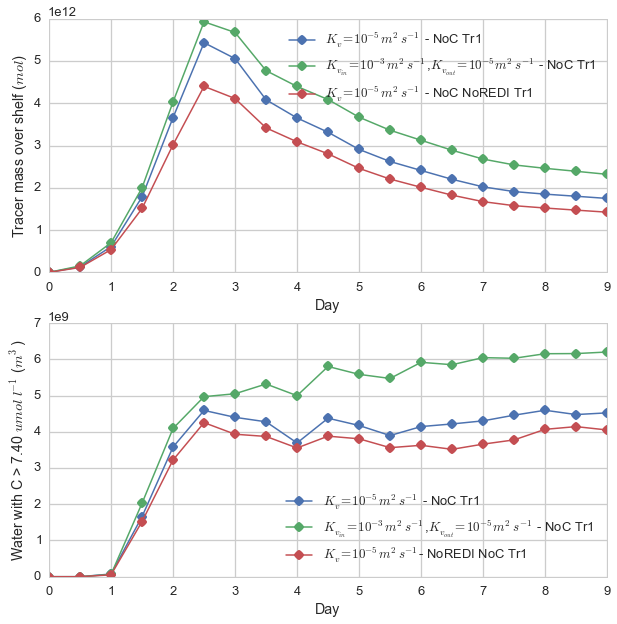

In [24]:
fig45=plt.figure(figsize=(10,10))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)


ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TotXTr1Iso1-TotXTr1NoC,'o-',label='$K_{v}=10^{-5}m^2s^{-1}$ - NoC Tr1')
line2 = ax1.plot(times/2.0, TotXTr33D-TotXTr1NoC,'o-', label='$K_{v_{in}}=10^{-3}m^2s^{-1}$,$K_{v_{out}}=10^{-5}m^2s^{-1}$ - NoC Tr1')
line2 = ax1.plot(times/2.0, TotXTr1NoR02-TotXTr1NoRNoC,'o-', label='$K_{v}=10^{-5}m^2s^{-1}$ - NoC NoREDI Tr1')


plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0, TotWatXTr1Iso1-TotWatXTr1NoC,'o-',label='$K_{v}=10^{-5}m^2s^{-1}$ - NoC Tr1')
line2 = ax2.plot(times/2.0, TotWatXTr33D-TotWatXTr1NoC,'o-', label='$K_{v_{in}}=10^{-3}m^2s^{-1}$,$K_{v_{out}}=10^{-5}m^2s^{-1}$ - NoC Tr1 ')
line2 = ax2.plot(times/2.0, TotWatXTr1NoR02-TotWatXTr1NoRNoC,'o-', label='$K_{v}=10^{-5}m^2s^{-1}$- NoREDI NoC Tr1 ')


plt.ylabel('Water with C > 7.40 $umol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


#fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/TrMassOverShelfCNT13DNoC1.eps', format='eps', dpi=1000,bbox_extra_artists=(leg,), bbox_inches='tight')


### Case 5 : Closed Boundaries at N and S.

In [25]:
xc5 = rout.getField(CanyonGrid05, 'XC') # x coords tracer cells
yc5 = rout.getField(CanyonGrid05, 'YC') # y coords tracer cells

drF5 = CanyonGridOut05.variables['drF'] # vertical distance between faces
dxG5 = rout.getField(CanyonGrid05,'dxG')

rA5 = rout.getField(CanyonGrid05, 'rA') # area of cells (x-y)
hFacC5 = rout.getField(CanyonGrid05, 'HFacC')
MaskC5 = rout.getMask(CanyonGrid05,'HFacC') # same for both runs

xc2 = rout.getField(CanyonGrid02, 'XC') # x coords tracer cells
yc2 = rout.getField(CanyonGrid02, 'YC') # y coords tracer cells

drF2 = CanyonGridOut02.variables['drF'] # vertical distance between faces
dxG2 = rout.getField(CanyonGrid02,'dxG')

rA2 = rout.getField(CanyonGrid02, 'rA') # area of cells (x-y)
hFacC2 = rout.getField(CanyonGrid02, 'HFacC')
MaskC2 = rout.getMask(CanyonGrid02,'HFacC') # same for both runs





In [26]:
Tr1NoREDIn05 = rout.getField(NoREDI05nTr,'Tr1') # Tracer 1 NoREDI run05 , Kz = E-5
Tr1NoREDIn02 = rout.getField(NoREDI02nTr,'Tr1') # Tracer 1 NoREDI run02 , Kz = E-5


In [27]:

TotWatXTr1ClBdy = np.empty(nt)
TotXTr1ClBdy = np.empty(nt)

TotWatXTr102new = np.empty(nt)
TotXTr102new = np.empty(nt)



for time in range(0,nt,1):
    print(time)    
    (WaterX1, TrX1) = HowMuchWaterX(Tr1NoREDIn05,MaskC5,29,rA5,hFacC5,drF5,time,nx,dxG5)
    (WaterX2, TrX2) = HowMuchWaterX(Tr1NoREDIn02,MaskC2,29,rA2,hFacC2,drF2,time,nx,dxG2)
    
    TotXTr1ClBdy[time] = np.sum((TrX1)*dxG[0,:])
    TotWatXTr1ClBdy[time] = np.sum((WaterX1)*dxG[0,:])
    
    TotXTr102new[time] = np.sum((TrX2)*dxG5[0,:])
    TotWatXTr102new[time] = np.sum((WaterX2)*dxG2[0,:])
   
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


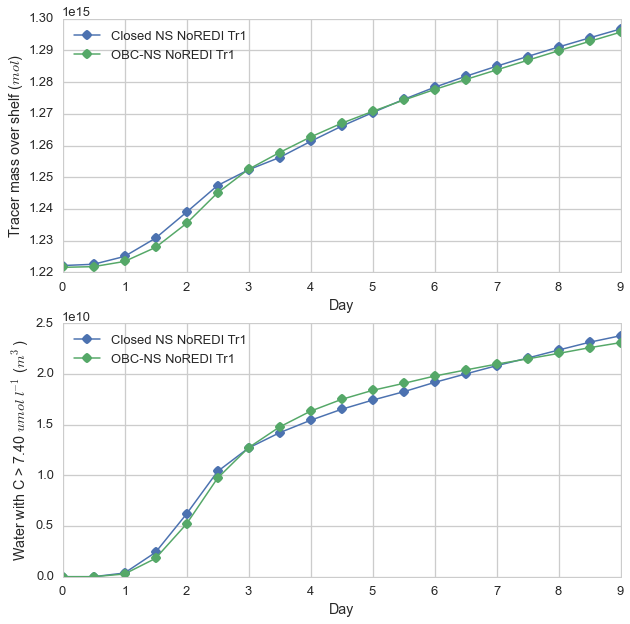

In [28]:
fig45=plt.figure(figsize=(10,10))
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1,rc={"lines.linewidth": 1.5})

times = np.arange(0,nt,1)


ax1 = plt.subplot(2,1,1)

line1 = ax1.plot(times/2.0, TotXTr1ClBdy,'o-',label='Closed NS NoREDI Tr1')
line2 = ax1.plot(times/2.0, TotXTr102new,'o-', label='OBC-NS NoREDI Tr1')


plt.ylabel('Tracer mass over shelf ($mol$) ')
plt.xlabel('Day')


ax2 = plt.subplot(2,1,2)

line1 = ax2.plot(times/2.0,TotWatXTr1ClBdy,'o-',label='Closed NS NoREDI Tr1')
line2 = ax2.plot(times/2.0, TotWatXTr102new,'o-',label='OBC-NS NoREDI Tr1')


plt.ylabel('Water with C > 7.40 $umol$ $l^{-1}$ ($m^3$)')
plt.xlabel('Day')
    
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc=0)
   
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels,loc=0)


In [29]:
print('%e mol' %(TotXTr1ClBdy[18]-TotXTr1ClBdy[0]))
print('%e mol' %(TotXTr102new[18]-TotXTr102new[0]))

7.462060e+13 mol
7.417446e+13 mol


###Results:

* Changing $k_{iso}$ from 10 to 0.01 $m^2s^{-1}$ has little effect on the total amount of tracer at the shelf at every snapshot. There is no extra tracer on the shelf when we consider the total mass of tracer on the shelf. The amount of water with concentration higher than 7.40 $umol/l$ is slightly larger for $k_{iso}$=10, similar for 1 and 0.1 and slightly lower if GMREDI is not used ($k_h=10^{-5}$).


* Larger isopycnal diffusivity generates more stirring rather than mixing. Stirring has little effect in changing the concentration since horizontal gradients are weak compared to the vertical ones. So, water that came up onto the shelf with high concentration will mix with the low concentration shelf water more slowly than in a low $k_{iso}$ case.


* Changing $k_{v3D}$ has little effect on the total amount of tracer at the shelf at every snapshot. There is no extra tracer on the shelf when we consider the total mas of tracer on the shelf. The amount of water with concentration higher than 7.40 $umol/l$ is slightly larger for $k_{v_{in}}=10^{-3}m^2s^{-1}$, $k_{v_{out}}=10^{-7}m^2s^{-1}$ and closely followed by $k_{v_{in}}=10^{-3}m^2s^{-1}$, $k_{v_{out}}=10^{-5}m^2s^{-1}$. Next is $k_{v_{in}}=10^{-4}m^2s^{-1}$, $k_{v_{out}}=10^{-7}m^2s^{-1}$ and the lowest is $k_{v}=10^{-5}m^2s^{-1}$ constant.


* These results suggest that having enhanced mixing in the canyon helps bring water with higher concentration onto the shelf, and then a lower vertical diffusivity suppresses the mixing on the shelf. The two processes competing are mixing within the canyon bringing high-concentration water onto the shelf and mixing on the shelf working to homogenize the concentration.


* Changing the vertical diffusivity in the whole domain has the large changes in total amout of tracer on the shelf and high-concentration water, but the most important factor is the presence of the canyon.


* With higher vertical diffusivity, total tracer mass on shelf is larger than for lower $K_v$ for the canyon case; if there is no canyon, the larger $k_v$ case has more tracer mass on the shelf.


* The high-concentration water is consistently higher for lower vertical diffussivity values. This is because water is mixed less in the lower $k_v$ cases everywhere in the domain.

* More mixing inside the canyon means more tracer due to more high-concentration water coming onto the shelf. This should be further tested when looking at advective and diffusive fluxes from the model.







